In [2]:
#install libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tueplots

import sys
print(sys.executable)

/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [3]:
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../paper/figures/'

#upload raw query data
df_32_raw = pd.read_csv(f'{source_path}repository_queries/500000_32_homicide-female_DE.csv') 
#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv')
#filter to only ones with T/F data
df_tag_valid = df_tag.dropna(subset=['woman_murdered'])
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv')
#upload top k data
df_50 = pd.read_csv(f'{source_path}processed/7-9_22_24_26-27_31-32_2017-2023_top50.csv')
df_25 = pd.read_csv(f'{source_path}processed/7-14_22-24_26-27_29-32_2017-2023_top25.csv')

#data filtered to only one entry per NUTS and date between 2017 -2023
df_32_raw['NUTS'] = df_32_raw['NUTS'].fillna('').astype(str)
print(f'df 32 raw  shape: {df_32_raw.shape}')
df_32 = df_32_raw.groupby('id').agg({
    'NUTS': lambda x: ', '.join(sorted(set(code for code in x if code.startswith('DE')))),
    'url': 'first',
    'hostname': 'first',
    'date': 'first',
    'cos_dist': 'first', # these values will all be the same
    'hashed_id': 'first',
    'date_crawled': 'first'
    }).reset_index()
#remove null NUTS
df_32 = df_32[df_32['NUTS'].notna()]
df_32 = df_32[df_32['NUTS']!='']

print(f'df 32 nuts condensed shape: {df_32.shape}')
#Convert the date column to datetime objects
df_32['date'] = pd.to_datetime(df_32['date'])      
# Filter for dates
df_32 = df_32[(df_32['date'].dt.year >= 2017) & (df_32['date'].dt.year <= 2023)]
print(f'df 32 date removed shape: {df_32.shape}')
df_32_threshold = df_32[df_32['cos_dist']<=.225].copy()
print(f'shape of df_32_threshold: {df_32_threshold.shape}')

df 32 raw  shape: (1143913, 13)
df 32 nuts condensed shape: (375215, 8)
df 32 date removed shape: (364570, 8)
shape of df_32_threshold: (31368, 8)


In [4]:
def query_relevant_list(df_topk, df_tag_valid,k): 
    # Join tagging information to top k
    df_query = df_topk.merge(df_tag_valid[['id', 'woman_murdered','URL_works']], on='id', how='left')
    print(f"shape topk: {df_topk.shape}")
    print(f"shape topk tagged: {df_query.shape}")

    # Convert all pd.NA to np.nan in the entire dataframe
    df_query = df_query.fillna(np.nan)
    
    # Get list of queries
    queries = [col.removeprefix('cos_rank_') for col in df_query.columns if col.startswith('cos_rank_')]
    
    query_list = []  # List to store all query results
    
    # For each query: create records with article id, relevance, cosine distance, and rank
    for query in queries:
        rank_col = f'cos_rank_{query}'
        dist_col = f'cos_dist_{query}'

        #We only want to rerank articles that were part of the top 50 check
        #create a subset of those items
        subset_topk = df_query[rank_col] < k

        df_query['new_rank'] = df_query[rank_col] #initialize with original rankings
         # Create new rank
        df_query.loc[subset_topk, 'new_rank'] = (
            df_query.loc[subset_topk, rank_col]
                .rank(method='dense', na_option='keep')
                .astype(float)
        )

        df_query['normalized_cos_dist'] = (df_query[dist_col] - df_query[dist_col].mean()) / df_query[dist_col].std()

        
        # Create records for this query
        for _, row in df_query.iterrows():
            query_list.append({
                'query': query,
                'article_id': row['id'],
                'relevance': row['woman_murdered'],
                'cosine_distance': row[dist_col],
                'original_rank': row[rank_col],
                'new_rank': row['new_rank'],
                'url_works': row['URL_works'], 
                'normalized_cos_dist' : row['normalized_cos_dist']
            })
    
    # Check the structure
    print(f"\nTotal records created: {len(query_list)}")
    print(f"Number of queries: {len(queries)}")
    
    # Show sample for first few queries
    for query in queries[:3]:
        query_records = [r for r in query_list if r['query'] == query]
        relevant = sum(1 for r in query_records if r['relevance'] == True)
        irrelevant = sum(1 for r in query_records if r['relevance'] == False)
        not_checkable = sum(1 for r in query_records if pd.isna(r['relevance']))
        print(f"\nQuery: {query}")
        print(f"  Relevant articles: {relevant}")
        print(f"  Irrelevant articles: {irrelevant}")
        print(f"  not_checkable articles: {not_checkable}")
        print(f"  Total articles: {len(query_records)}")

    query_df = pd.DataFrame(query_list)
    return query_df

# Usage:
# query_list = query_relevant_list(df_topk, df_tag_valid)
# df_results = pd.DataFrame(query_list)


In [5]:
df_50_ind = query_relevant_list(df_50, df_tag_valid,50)

df_25_dind = query_relevant_list(df_25, df_tag_valid,25)

shape topk: (306, 24)
shape topk tagged: (306, 26)

Total records created: 2754
Number of queries: 9

Query: 7_police-report-gender-motivated_EN
  Relevant articles: 187
  Irrelevant articles: 69
  not_checkable articles: 50
  Total articles: 306

Query: 8_police-report-gender-motivated_DE
  Relevant articles: 187
  Irrelevant articles: 69
  not_checkable articles: 50
  Total articles: 306

Query: 9_woman-girl-killed_EN
  Relevant articles: 187
  Irrelevant articles: 69
  not_checkable articles: 50
  Total articles: 306
shape topk: (263, 40)
shape topk tagged: (263, 42)

Total records created: 4471
Number of queries: 17

Query: 7_police-report-gender-motivated_EN
  Relevant articles: 165
  Irrelevant articles: 68
  not_checkable articles: 30
  Total articles: 263

Query: 8_police-report-gender-motivated_DE
  Relevant articles: 165
  Irrelevant articles: 68
  not_checkable articles: 30
  Total articles: 263

Query: 9_woman-girl-killed_EN
  Relevant articles: 165
  Irrelevant articles: 6

In [8]:
df_query = pd.DataFrame(df_50_dict)

# Iterate over keys
for key in df_50_dict:
    print(key)

{'query': '7_police-report-gender-motivated_EN', 'article_id': '600f9f30-15cc-435d-9cab-56d475bd02f8', 'relevance': True, 'cosine_distance': 0.2333228, 'original_rank': 1.0, 'new_rank': 1.0, 'url_works': 'Active', 'normalized_cos_dist': -2.1879019765847962}
{'query': '7_police-report-gender-motivated_EN', 'article_id': '282205b9-ce04-4462-b96d-d37ac43b6eca', 'relevance': True, 'cosine_distance': 0.23627424, 'original_rank': 2.0, 'new_rank': 2.0, 'url_works': 'Active', 'normalized_cos_dist': -2.0584189796010546}
{'query': '7_police-report-gender-motivated_EN', 'article_id': 'd6d2633e-35b4-4496-8896-e57b9bea0ac8', 'relevance': True, 'cosine_distance': 0.23867315, 'original_rank': 3.0, 'new_rank': 3.0, 'url_works': '404 or redirect to home page', 'normalized_cos_dist': -1.953176096027522}
{'query': '7_police-report-gender-motivated_EN', 'article_id': '2d9f1ebf-e4f4-4f74-96d6-208bd48239f4', 'relevance': True, 'cosine_distance': 0.24109761, 'original_rank': 4.0, 'new_rank': 4.0, 'url_works'

In [180]:
def add_jitter_if_duplicates(ranks, y_pos, jitter_amount=0.15):
    """Add vertical jitter only to ranks that have duplicates"""
    y_positions = np.array([y_pos] * len(ranks), dtype=float)
    
    if len(ranks) == 0:
        return y_positions
    
    # Find which ranks have duplicates
    unique_ranks, counts = np.unique(ranks, return_counts=True)
    duplicate_ranks = unique_ranks[counts > 1]
    
    # Add jitter only to duplicate ranks
    for rank in duplicate_ranks:
        mask = ranks == rank
        num_duplicates = np.sum(mask)
        y_positions[mask] += np.random.uniform(-jitter_amount, jitter_amount, num_duplicates)
    
    return y_positions


def plot_query_outcomes(query_data, x_col='cos_rank_', rel_col ='new_rank' , mainquery=None, threshold=None, tagdata=None, lengthstart=0, lengthend=100, jitter_amount=0.15):
    # Convert list to dataframe for easier grouping
    df_query = pd.DataFrame(query_data)
    queries = df_query['query'].unique()
    
    fig, ax = plt.subplots(figsize=(18, len(queries) * 0.8))
    
    for i, query in enumerate(queries):
        y_pos = i
        x_col = f'{x_col}{query}'
        
        # Filter data for this query
        query_subset = df_query[df_query['query'] == query]

        if mainquery is not None and threshold is not None and tagdata is not None:
            column = f'{x_col}{mainquery}'  
            excluded_ids = tagdata[tagdata[column] >= threshold]['id'].values
            
            relevant_subset = tagdata['woman_murdered'] == True
            excluded_subset = tagdata['id'].isin(excluded_ids)
            
            rel_excl = tagdata[relevant_subset & excluded_subset][x_col].values
            irrel_excl = tagdata[~relevant_subset & excluded_subset][x_col].values
            
            # Add jitter only if duplicates exist
            rel_excl_y = add_jitter_if_duplicates(rel_excl, y_pos, jitter_amount)
            irrel_excl_y = add_jitter_if_duplicates(irrel_excl, y_pos, jitter_amount)
            
            ax.plot(rel_excl, rel_excl_y,
                    's', alpha=0.7, color='orange', ms=6, mec='black', mew=1.5,
                    label=f'Relevant ({mainquery} excluded)' if i == 0 else '')
            ax.plot(irrel_excl, irrel_excl_y,
                    's', alpha=0.7, color='blue', ms=6, mec='black', mew=1.5,
                    label=f'Irrelevant ({mainquery} excluded)' if i == 0 else '')
        
        # Get relevant and irrelevant from the list/dataframe
        relevant = query_subset[query_subset['relevance'] == True][rel_col].values
        irrelevant = query_subset[query_subset['relevance'] == False][rel_col].values
        na = query_subset.loc[query_subset['relevance'].isna(), rel_col].values
        
        # Add jitter only if duplicates exist
        relevant_y = add_jitter_if_duplicates(relevant, y_pos, jitter_amount)
        irrelevant_y = add_jitter_if_duplicates(irrelevant, y_pos, jitter_amount)
        na_y = add_jitter_if_duplicates(na, y_pos, jitter_amount)
        
        ax.plot(relevant, relevant_y,
                'o', alpha=0.7, color='orange', ms=4, mec='none', 
                label='Relevant' if i == 0 else '')
        ax.plot(irrelevant, irrelevant_y,
                'o', alpha=0.7, color='blue', ms=4, mec='none', 
                label='Irrelevant' if i == 0 else '')
        ax.plot(na, na_y,
                'o', alpha=0.7, color='grey', ms=4, mec='none', 
                label='NA' if i == 0 else '')
        
        all = np.concatenate([relevant, irrelevant, na])
        
    ax.set_yticks(range(len(queries)))
    ax.set_yticklabels(queries)
    
    for i in range(len(queries)):
        if i > 0:
            ax.axhline(i - 0.5, color='gray', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel(f'{x_col}', fontsize=12)
    ax.set_xlim(lengthstart, lengthend)
    ax.set_ylim(-0.5, len(queries) - 0.5)
    ax.axvline(50, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(25, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)
    ax.set_title(f"Article {x_col} by Query with Relevance", fontsize=14, pad=20)
    
    plt.tight_layout()
    return fig, ax

(<Figure size 1800x1360 with 1 Axes>,
 <Axes: title={'center': 'Article cos_rank_7_police-report-gender-motivated_EN8_police-report-gender-motivated_DE9_woman-girl-killed_EN10_woman-girl-killed_DE11_murder-woman-victim_EN12_murder-woman-victim_DE13_victim-woman-long_EN14_victim-woman-long_DE22_femicide_Femizid_DE23_femicide_Frauenmord_DE24_femicide_Feminizid_DE26_femicide_Femicide_EN27_femicide_femicide_EN29_woman-was-murdered_DE30_woman-was-killed_DE31_murder-woman-girl_DE32_homicide-female_DE by Query with Relevance'}, xlabel='cos_rank_7_police-report-gender-motivated_EN8_police-report-gender-motivated_DE9_woman-girl-killed_EN10_woman-girl-killed_DE11_murder-woman-victim_EN12_murder-woman-victim_DE13_victim-woman-long_EN14_victim-woman-long_DE22_femicide_Femizid_DE23_femicide_Frauenmord_DE24_femicide_Feminizid_DE26_femicide_Femicide_EN27_femicide_femicide_EN29_woman-was-murdered_DE30_woman-was-killed_DE31_murder-woman-girl_DE32_homicide-female_DE'>)

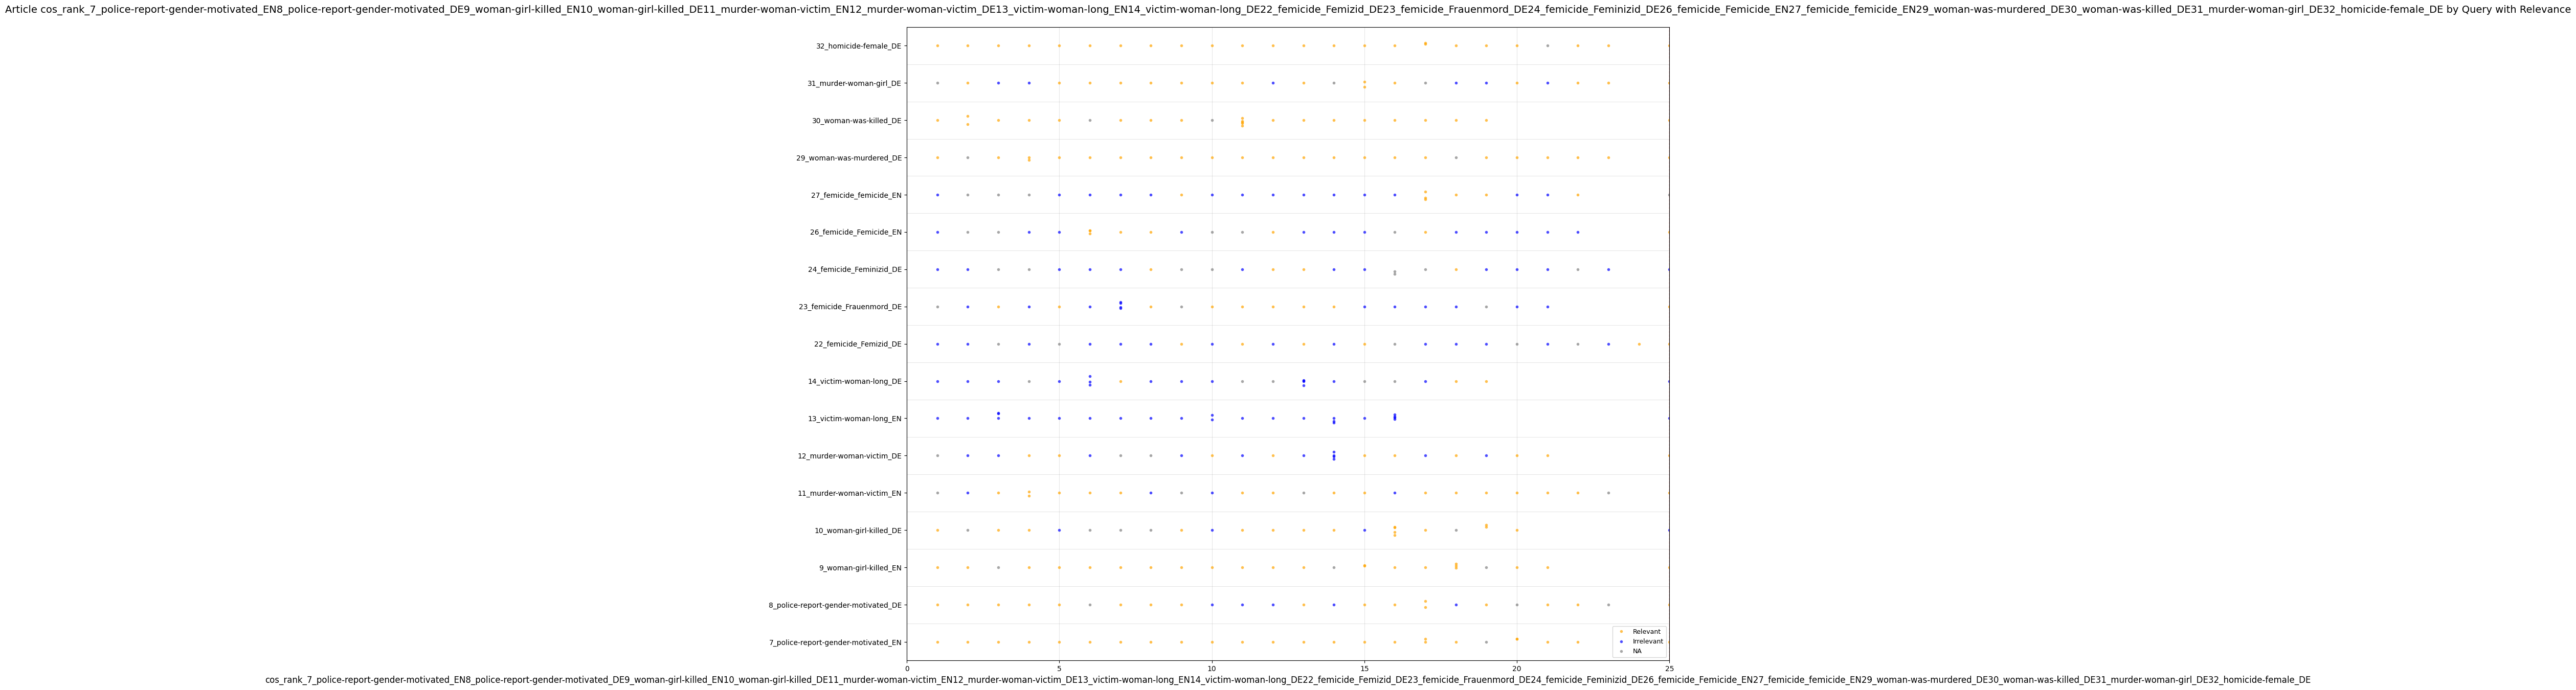

In [183]:
plot_query_outcomes(df_25_dict, x_col='cos_rank_', rel_col = 'new_rank', 
                    mainquery=None, threshold=None, tagdata=None, lengthstart=0, lengthend=25)
#fig.savefig(f'{figure_output_path}query_ranks_deduplicated_top50_plot.png', dpi=300, bbox_inches='tight')

(<Figure size 1200x720 with 1 Axes>,
 <Axes: title={'center': 'Article Ranks by Query and Relevance'}, xlabel='Rank'>)

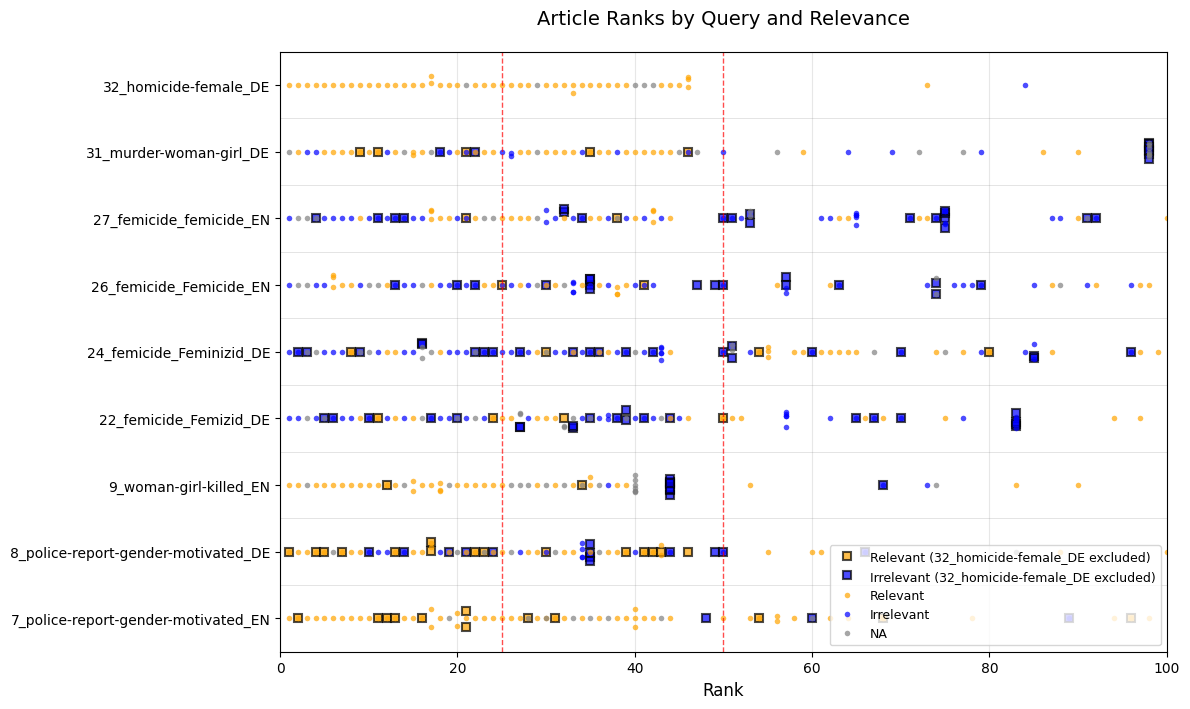

In [128]:
tagdata = df_50.merge(df_tag_valid[['id', 'woman_murdered']], on='id', how='left')

tagdata.head()
plot_query_ranks(df_50_dict, mainquery="32_homicide-female_DE", threshold=.225, tagdata=tagdata)

In [100]:
#duplicate check
df_tag_sourcecos_duplicates = df_tag.copy()
print(f"df_tag shape: {df_tag.shape}")
df_tag['id'].unique().shape
print(f"df_tag unique id shape: {df_tag['id'].unique().shape}")

df_tag_sourcecos_duplicates = df_tag_sourcecos_duplicates.merge(df_32[['id', 'url', 'date', 'date_crawled', 'NUTS','hashed_id','hostname','cos_dist']], on='id', how='left')
print(f"df_tag_sourcecos_duplicates after df_32 merge shape: {df_tag_sourcecos_duplicates.shape}")
print(f"df_tag_sourcecos_duplicates unique id shape: {df_tag_sourcecos_duplicates['id'].unique().shape}")

#add column to check article duplicates if the article has the same source and same cosine distance
df_tag_sourcecos_duplicates['cos_hostname_duplicate_count'] = df_tag_sourcecos_duplicates.groupby(['cos_dist', 'hostname'])['cos_dist'].transform('count')
print(f"df_tag_sourcecos_duplicates after cosdist shape: {df_tag_sourcecos_duplicates.shape}")
print(f"df_tag_sourcecos_duplicates after cosdist unique id shape: {df_tag_sourcecos_duplicates['id'].unique().shape}")


df_tag_sourcecos_duplicates.to_csv(f'{csv_output_path}duplicate_check.csv', index=False)

df_tag shape: (1191, 19)
df_tag unique id shape: (1191,)
df_tag_sourcecos_duplicates after df_32 merge shape: (1191, 26)
df_tag_sourcecos_duplicates unique id shape: (1191,)
df_tag_sourcecos_duplicates after cosdist shape: (1191, 27)
df_tag_sourcecos_duplicates after cosdist unique id shape: (1191,)


In [102]:
#how many total items in our dataset (under the threshold) have same hostname and cosine distance
#filter to threshold
df_32_threshold = df_32[df_32['cos_dist']<=.225].copy()
print(f'shape of df_32_threshold: {df_32_threshold.shape}')

#add column to check article duplicates if the article has the same source and same cosine distance
df_32_threshold['cos_hostname_duplicate_count'] = df_32_threshold.groupby(['cos_dist', 'hostname'])['cos_dist'].transform('count')

# mark retained rows
df_32_threshold['retained'] = ~df_32_threshold.duplicated(
    subset=['cos_dist', 'hostname'],
    keep='first'
)

#filter to only rows with duplicates and save csv

df_32_threshold[df_32_threshold['cos_hostname_duplicate_count']>1].to_csv(f'{csv_output_path}duplicate_q32thresh_flagged.csv', index=False)

# keep only retained rows
df_32thresh_nodups = df_32_threshold[df_32_threshold['retained']].copy()

print(f'shape of df_32_threshold_nodups: {df_32_threshold_nodups.shape}')

print(f'total_duplicates_removed = {df_32_threshold.shape[0] - df_32_threshold_nodups.shape[0]}')

total_duplicates_removed/df_32_threshold_shape

df_32thresh_nodups.to_csv(f'{csv_output_path}query32_filtered_nuts-date_removecoshostdupcs.csv', index=False)

shape of df_32_threshold: (34121, 8)
shape of df_32_threshold_nodups: (33654, 10)
total_duplicates_removed = 467


In [115]:
#compare to Zoe CSV: if we filter to article ids in my data, should be same #
#upload data
df_32_filtered = pd.read_csv(f'{source_path}/final_dataset_t225.csv')
print(f'df_32_filtered {df_32_filtered.shape}')
print(f'shape of df_32_threshold: {df_32_threshold.shape}')

#list of ids in df_32thresh_nodups

#list of ids in df_32thresh_nodups
ids_dedup = df_32thresh_nodups['id']

df_32_filtered_idCompare = df_32_filtered[df_32_filtered['id'].isin(ids_dedup)]
print(f'df_32_filtered_idCompare {df_32_filtered_idCompare.shape}')
print(f'shape of df_32_threshold_nodups: {df_32_threshold_nodups.shape}')

df_32_filtered (31368, 8)
shape of df_32_threshold: (34121, 10)
df_32_filtered_idCompare (30194, 8)
shape of df_32_threshold_nodups: (33654, 10)


In [ ]:
        # Remove duplicates - defer to rows that have URL_works == True or 'Active'
        # Create priority: 1 for working URLs, 0 for non-working
       # df_query['url_priority'] = df_query['URL_works'].apply(lambda x: 1 if x in [True, 'Active', 'active'] else 0)
        #df_query = df_query.sort_values('url_priority', ascending=False)
        #df_query = df_query.drop_duplicates(subset=[dist_col], keep='first')
        #df_query = df_query.drop(columns=['url_priority'])
    